In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')


Nonlinear Regression  - 1D Data

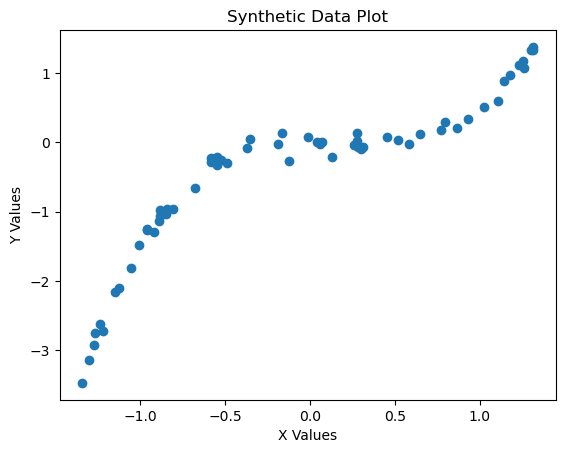

In [20]:
# Set random state
rnd = np.random.RandomState(42)

N = 60 # Number of datapoints
data_max, data_min = 1.4, -1.4 # Assign range of data
len_data = (data_max - data_min) # Get length of data range
data = np.sort(rnd.rand(N) * len_data - len_data/2) # Build and order synthetic data
noise = rnd.randn(N) * 0.1 # Create normally distributed random noise values
target = data ** 3 - 0.5 * data ** 2 + noise # Build polynomial response variable

# Scatter plot of synthetic data
plt.scatter(data, target)
plt.xlabel('X Values')
plt.ylabel('Y Values')
plt.title('Synthetic Data Plot')
plt.show()
